<a href="https://colab.research.google.com/github/avkornaev/Cells_counter/blob/main/PlayWithUncertaintyVol2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solver

In [1]:
Solver = 'Colab' #'Container', 'Local', 'Colab'
isFirstStart = True

# Install libraries (with the very first run)

In [2]:
if isFirstStart:
    !pip install efficientnet_pytorch
    !pip install neptune-client numpy==1.19.5 torch==1.9.0 torchvision==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4a396948ff78748c8d38c5d6c7b478165e7bf4659ae791febf66b08094078d95
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.1/22.1 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import neptune.new as neptune
from neptune.new.types import File
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import load_pretrained_weights

# if Solver =='Colab':
#     from google.colab import drive
#     drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.8/dist-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-3-740e95e766d7>:7: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [4]:
run = neptune.init_run(
    project="avkornaev/Play-with-uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
)  # your credentials

<ipython-input-4-cf1e534ade21>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/avkornaev/Play-with-uncertainty/e/PLAY-253


## Initialization

Device config

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
#device = 'cpu'

Normalization

In [7]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.255])

Settings

In [8]:
DATASET = 'CIFAR-10'#'Hymenoptera'# or 'PetImages','CIFAR-10'
LOSS_FUN = 'CrossEntropy'#'CrossEntropyWithU'#or 'CrossEntropy'
ARCHITECTURE = 'EffNet'
SAVE_RES = True
START_WITH_SAVED = False #download saved model

SIZE = 224 #image size

NUM_CLASSES = 10

THRESHOLD_RATIO = torch.linspace(0,0.9,10)

NOISE_IN_LABELS_RATIO = 0.15

num_epochs = 11
batch_size = 100
img_channels = 3

lr = 1E-1
step_size = 50
gamma = 1

#Set specific learning rates in the network layers
N_LAYERS_FOR_LR_CORRECTION = 0#number of the last few layers of the network
lr_mult = 1E+0 # learning rate multiplier


PATH = './cnn.pth'

parameters = {
    "lr": lr,
    "step_size":step_size,
    "gamma":gamma,
    "dataSet": DATASET,
    "bs": batch_size,
    "num_epochs": num_epochs,
    "input_sz": [img_channels, SIZE, SIZE],
    "n_classes": NUM_CLASSES,
    "criterion": LOSS_FUN,
    "model_filename": ARCHITECTURE,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

## Log parameters

In [9]:
run["config/hyperparameters"] = parameters

<ipython-input-9-f1088bc37539>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["config/hyperparameters"] = parameters
<ipython-input-9-f1088bc37539>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torch.device'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["config/hyperparameters"] = parameters


# Create data sets and data loaders

## Path
Hymenoptera_data: <https://download.pytorch.org/tutorial/hymenoptera_data.zip>

CIFAR-10 https://www.kaggle.com/competitions/cifar-10/data

In [10]:
DATASET

'CIFAR-10'

In [11]:
if DATASET == 'Hymenoptera':
    data_dir = '/WRITE_ACCESS_STORAGE/hymenoptera_data'
elif DATASET == 'PetImages':
    data_dir = '/WRITE_ACCESS_STORAGE/PetImages'
elif DATASET == 'CIFAR-10':
    data_dir = '/content/drive/MyDrive/dataSets/CIFAR-10'

## Transforms

Inputs transforms

In [12]:
if DATASET == 'CIFAR-10':
    data_transforms = {'train': transforms.Compose(
        [transforms.Resize((SIZE, SIZE)),
        transforms.RandomRotation(15),
        transforms.RandomAdjustSharpness(2,p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.5,scale=(5E-2, 1E-1),value='random', inplace=False)]),
        'test': transforms.Compose(
            [transforms.Resize((SIZE, SIZE)),
            transforms.RandomRotation(15),
            transforms.RandomAdjustSharpness(2,p=0.5),
            transforms.RandomAutocontrast(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.RandomErasing(p=0.5,scale=(5E-2, 1E-1),value='random', inplace=False)])}
else:
    data_transforms = {
        'train': transforms.Compose(
            [transforms.RandomResizedCrop(SIZE,scale=(0.05, 0.1)),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAdjustSharpness(2,p=0.5),
            transforms.RandomAutocontrast(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)]),
        'test': transforms.Compose(
            [transforms.RandomResizedCrop(SIZE,scale=(0.05, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])}

#      'test': transforms.Compose(
#          [transforms.Resize(256),
#           transforms.RandomCrop(SIZE),
#           transforms.ToTensor(),
#           transforms.Normalize(mean, std)])

Labels transform (noise in labels)

In [13]:
def labelNoise(labels, phase, num_classes=10, p=0):
    '''
    phase is 'train' or 'test'
    '''
    if phase == 'train':
        a = torch.randperm(len(labels)) # shuffled list
        for i in a[:np.int(np.round(len(labels)*p))]:
            labels[i] = torch.randint(0, NUM_CLASSES,(1,1))
    return labels
    # if phase == 'train':
    #     a = torch.randperm(len(labels)) # shuffled list
    #     for i in a[:np.int(np.round(len(labels)*p))]:
    #         if labels[i] == 1:
    #             labels[i] = 9
    #         elif labels[i] == 9:
    #             labels[i] = 1
    #         elif labels[i] == 4:
    #             labels[i] = 7
    #         elif labels[i] == 7:
    #             labels[i] = 4
    #         elif labels[i] == 3:
    #             labels[i] = 5
    #         elif labels[i] == 5:
    #             labels[i] = 3
    #         # if labels[i] < 5:
    #         #     labels[i] = torch.randint(0, 5,(1,1))
    # return labels

In [14]:
# #a = range(NUM_CLASSES)
# a = torch.randperm(NUM_CLASSES)

# for i in a[:np.int(np.round(len(a)*0.5))]:
#   print(i)
# len(a)
# torch.randint(0, NUM_CLASSES,(1,1))

## Data sets and data loaders: training and test

In [15]:
if DATASET == 'CIFAR-10':
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=data_transforms['train'])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
    
    image_datasets = {'train': trainset, 'test': testset}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    dataloaders = {'train': trainloader, 'test': testloader}
    class_names = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    class_names = image_datasets['train'].classes
print('class names: ',class_names)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/dataSets/CIFAR-10/cifar-10-python.tar.gz to /content/drive/MyDrive/dataSets/CIFAR-10
Files already downloaded and verified
class names:  ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualization

In [16]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

Training

In [17]:
inputs_train, classes_train = next(iter(dataloaders['train']))

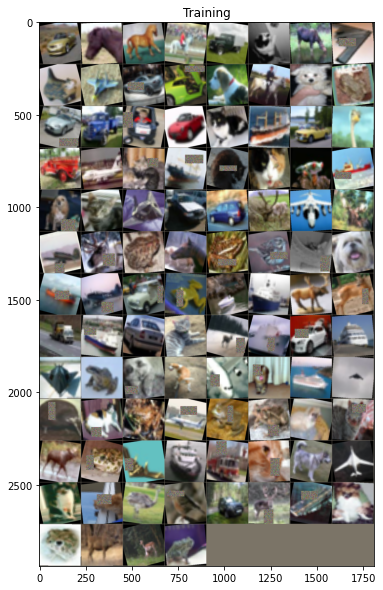

['car', 'horse', 'horse', 'horse', 'truck', 'cat', 'deer', 'plane', 'cat', 'plane', 'car', 'car', 'dog', 'horse', 'dog', 'frog', 'car', 'truck', 'truck', 'car', 'cat', 'ship', 'car', 'bird', 'truck', 'plane', 'cat', 'ship', 'cat', 'cat', 'frog', 'ship', 'dog', 'cat', 'plane', 'car', 'car', 'deer', 'plane', 'deer', 'plane', 'deer', 'frog', 'horse', 'frog', 'bird', 'cat', 'dog', 'ship', 'plane', 'car', 'frog', 'ship', 'ship', 'deer', 'deer', 'truck', 'ship', 'car', 'cat', 'deer', 'ship', 'car', 'ship', 'plane', 'frog', 'cat', 'dog', 'plane', 'cat', 'ship', 'plane', 'bird', 'cat', 'frog', 'plane', 'frog', 'frog', 'dog', 'cat', 'deer', 'frog', 'plane', 'ship', 'truck', 'cat', 'dog', 'plane', 'cat', 'cat', 'bird', 'bird', 'car', 'deer', 'ship', 'dog', 'frog', 'deer', 'deer', 'frog']


In [18]:
fig = plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(inputs_train)
imshow(out,title='Training')
print([class_names[x] for x in classes_train])

**Test**

In [19]:
inputs_test, classes_test = next(iter(dataloaders['test']))

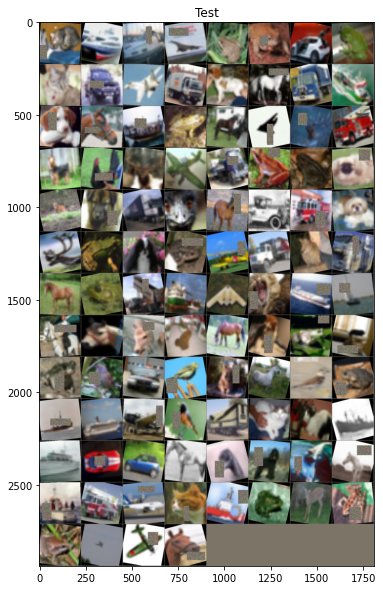

['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'bird', 'deer', 'car', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'plane', 'truck', 'cat', 'truck', 'horse', 'frog', 'truck', 'ship', 'plane', 'cat', 'ship', 'ship', 'horse', 'horse', 'deer', 'frog', 'horse', 'cat', 'frog', 'cat', 'frog', 'bird', 'car', 'bird', 'cat', 'horse', 'bird', 'frog', 'ship', 'ship', 'plane', 'bird', 'truck', 'cat', 'cat', 'ship', 'ship', 'car', 'car', 'horse', 'bird', 'dog', 'bird', 'horse', 'ship', 'truck', 'plane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'plane', 'plane', 'horse']


In [20]:
fig = plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(inputs_test)
imshow(out, title='Test')
print([class_names[x] for x in classes_test])

## Log the dataset details

In [21]:
run["config/dataset/path"] = data_dir
run["config/dataset/transforms"] = data_transforms
run["config/dataset/size"] = dataset_sizes

<ipython-input-21-e6f053a96d16>:2: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.transforms.transforms.Compose'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["config/dataset/transforms"] = data_transforms


# Model architecture: a network with 2 heads for predicions and uncertainties (when LOSS_FUN == 'CrossEntropyWithU'), or with 1 head for predictions only

In [22]:
class EfficientNetAux(EfficientNet):
    def __init__(self, blocks_args=None, global_params=None):
        super().__init__(blocks_args, global_params)    
    
    def extract_features(self, inputs):
        """use convolution layer to extract feature .
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        #seg = self._seg(x)
        #print(seg)
        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x #, seg
    
    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        #x, seg = self.extract_features(inputs)
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        
        #seg = self._avg_pooling(x)
        
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            out = self._fc(x)
#             merged = torch.cat([x,out],1)
#             if LOSS_FUN == 'CrossEntropyWithU':
#                 seg = self._seg(merged) #torch.cat((x, out), axis=1)
#                 out = torch.cat([out,seg],1)
        return out #(out, seg)    
    
    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False,
                        in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path,
                                load_fc=(num_classes == 1000), advprop=advprop)
        model._change_in_channels(in_channels)
        if LOSS_FUN == 'CrossEntropyWithU':
            model._fc = nn.Linear(in_features=model._fc.in_features, out_features=NUM_CLASSES*2, bias=True)
        else:
            model._fc = nn.Linear(in_features=model._fc.in_features, out_features=NUM_CLASSES, bias=True)
#         if LOSS_FUN == 'CrossEntropyWithU':
#             model._seg = nn.Linear(in_features=model._fc.in_features + NUM_CLASSES, out_features=NUM_CLASSES, bias=True)
        
        return model

In [23]:
if LOSS_FUN == 'CrossEntropyWithU':
    print(LOSS_FUN)

## Accuracy with and without uncertainty estimation

In [24]:
def accuracy_with_and_without_u(inputs,labels,model,num_classes=NUM_CLASSES):
    
    # predictions and uncertainties (output of the model), size = num_epochs x num_classes*2
    pred_u = model(inputs) 
    
    #predictions
    pred = nn.functional.softmax(pred_u[:,:num_classes], 1)
    
    #uncertainties and certainties
    unc = torch.sigmoid(pred_u[:,num_classes:] * 100).round() #binary values = {0,1}
    unc_1 = 1.0 - unc
            
    # values (hidden), indexes for all predictions (certain and uncertain)
    probv, pred = torch.max(pred, 1)
    n_samples = labels.shape[0]
    n_correct = (pred == labels).sum().item()
    
    # certain predictions
    best_THRESHOLD_RATIO = 0
    if LOSS_FUN == 'CrossEntropyWithU':
        #loss with uncertainties
        certain_pred = unc_1.gather(1, pred.unsqueeze(1)) 
        n_samples_cer = (certain_pred == 1).sum().item()
        n_correct_cer = torch.logical_and((pred == labels), (certain_pred.transpose(0,1) == 1)).sum().item()
    else:
        acc_with_u_current = 0
        certain_pred = torch.ones(pred.size()) #certain by default
        n_samples_cer = torch.tensor(pred.size())
        n_correct_cer = 0
        for i in THRESHOLD_RATIO:
            certain_pred_temp = ((probv<(1-i)*0.5) | (probv>(1+i)*0.5))*1.0
            n_samples_cer_temp = (certain_pred_temp == 1).sum().item() 
            n_correct_cer_temp = torch.logical_and((pred == labels), (certain_pred_temp == 1)).sum().item()
           
            if n_samples_cer_temp < 1.0:
                acc_with_u_temp = 0
            else:
                acc_with_u_temp = n_correct_cer_temp / n_samples_cer_temp
            #save the best
            if acc_with_u_temp > acc_with_u_current:
                certain_pred = certain_pred_temp
                n_samples_cer = n_samples_cer_temp 
                n_correct_cer = n_correct_cer_temp
                best_THRESHOLD_RATIO = i
                
    acc_without_u = n_correct / n_samples
    if n_samples_cer < 1.0:
        acc_with_u = 0
    else:
        acc_with_u = n_correct_cer / n_samples_cer
    
    accuracy_attr = {
        'outputs': pred_u,
        'pred':pred,
        'certain_pred':certain_pred,
        'n_samples':n_samples,
        'n_correct':n_correct,
        'certain_pred':certain_pred,
        'n_samples_cer':n_samples_cer,
        'n_correct_cer':n_correct_cer,
        'acc_without_u':acc_without_u,
        'acc_with_u':acc_with_u,
        'best_threshold_ratio': best_THRESHOLD_RATIO
    }
    
    return accuracy_attr   

# Training atributes

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()
  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))#, f'loss = {L.item():.8f}')
        #print('-' *10)

        #Each epoch has a training and validation phase
        for phase in ['train','test']:
            if phase == 'train':
                model.train()# set model to training mode
            else:
                model.eval() # set model evaluate mode
      
            running_loss = 0.0
            running_corrects = 0.0
            running_n_samples = 0.0
            running_corrects  = 0.0
            running_n_samples_cer = 0.0
            running_corrects_cer  = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #print('labels before adding noise',labels)
                labels = labelNoise(labels, phase, num_classes=NUM_CLASSES, p=NOISE_IN_LABELS_RATIO)
                labels = labels.to(device)
                #print('labels after adding noise',labels)

                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    #for one batch
                    accuracy_attr = accuracy_with_and_without_u(inputs=inputs, labels=labels, model=model)
                    outputs = accuracy_attr['outputs']
                    preds = accuracy_attr['pred']
                    n_samples = accuracy_attr['n_samples']
                    n_correct = accuracy_attr['n_correct']
                    n_samples_cer = accuracy_attr['n_samples_cer']
                    n_correct_cer = accuracy_attr['n_correct_cer']
                    best_threshold_ratio = accuracy_attr['best_threshold_ratio']
                    
                    loss = criterion(outputs, labels)
                    acc_without_u = n_correct/n_samples
                    if n_samples_cer < 1.0:
                        acc_with_u = 0
                    else:
                        acc_with_u = n_correct_cer / n_samples_cer
                       
            
                    # Log batch loss and accuracy
                    if phase == 'train':
                        run["training/batch/loss_training"].log(loss)
                        run["training/batch/n_samples_cer"].log(n_samples_cer)
                        run["training/batch/n_correct_cer"].log(n_correct_cer)
                        run["training/batch/btr"].log(best_threshold_ratio)
                        run["training/batch/acc_training_without_U"].log(acc_without_u)
                        run["training/batch/acc_training_with_u"].log(acc_with_u)
                        
                    elif phase == 'test':
                        run["training/batch/loss_validation"].log(loss)
                        run["training/batch/n_samples_cer"].log(n_samples_cer)
                        run["training/batch/n_correct_cer"].log(n_correct_cer)
                        run["training/batch/btr"].log(best_threshold_ratio)
                        run["training/batch/acc_validation_without_u"].log(acc_without_u)
                        run["training/batch/acc_validation_with_u"].log(acc_with_u)
                        
            
                    #backward
                    #track history
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                #Statistics
                running_loss += loss.item()*inputs.size(0)   
                running_n_samples += n_samples
                running_corrects  += n_correct #torch.sum(preds == labels.data)
                running_n_samples_cer+= n_samples_cer
                running_corrects_cer += n_correct_cer
                
    
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        if LOSS_FUN == 'CrossEntropyWithU':
            epoch_acc = running_corrects_cer / running_n_samples_cer
        elif LOSS_FUN == 'CrossEntropy':
            epoch_acc = running_corrects / running_n_samples

        print('{} Loss: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        #deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Learning rates throught the network layers

https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2022/03/29/discriminative-lr.html

In [26]:
def set_learning_rates(layer_names, lr=lr, lr_mult=lr_mult, numLayers=N_LAYERS_FOR_LR_CORRECTION, typeMul='constant'):
    ''' typeMul 'constant' or 'variable' learning rates
    '''
    # placeholder
    model_parameters = []
    if numLayers == 0:
        lr_mult = 1
    prev_group_name = layer_names[0].split('.')[0]
    # store params & learning rates
    print('Correctet learning rates:')
    for idx, name in enumerate(layer_names[-numLayers:]):
        # parameter group name
        cur_group_name = name.split('.')[0]
        # update learning rate
        if cur_group_name != prev_group_name:
            if typeMul == 'constant':
                lr = lr*lr_mult
            elif typeMul == 'variable':
                lr *= lr_mult
        prev_group_name = cur_group_name
        # display info
        print(f'{idx}: lr = {lr:.6f}, {name}')
        # append layer parameters
        model_parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
    return model_parameters

# Loss

https://discuss.pytorch.org/t/custom-loss-functions/29387/8

https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms

In [27]:
trans_to_zeros_and_ones = lambda y: torch.zeros(
    (batch_size,NUM_CLASSES), dtype=torch.float).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)

In [28]:
def my_cross_entropy(x, y):
    log_prob = -1.0 * nn.functional.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    #print(f'x = {x}, y = {y}, log_prob = {log_prob}, loss = {loss}')
    loss = loss.mean()
    #print(f'x = {x}, y = {y}, log_prob = {log_prob}, loss = {loss.item():.5f}')
    
    return loss

def my_cross_entropy_with_u(x, y, c=1):
    
    #Probabilities
    prob = nn.functional.softmax(x[:,:NUM_CLASSES], 1)

    #Uncertainties and certainties
#     unc = torch.sigmoid(input[:,NUM_CLASSES:]) - 0.5
#     with torch.no_grad():
#         unc = torch.sign(input[:,NUM_CLASSES:])
#         unc = torch.relu(unc)
#         unc_1 = 1.0 - unc
    
    #Uncertainties and certainties (plan B) 
#     unc = torch.sigmoid(input[:,NUM_CLASSES:]) - 0.5
#     #unc = torch.sign(input[:,NUM_CLASSES:])
#     unc = torch.sign(unc)
#     unc = torch.relu(unc)
#     unc_1 = 1.0 - unc
    
    #Uncertainties and certainties (plan C) - doesn't work
    unc = torch.sigmoid(x[:,NUM_CLASSES:]*c)
    unc = (unc - 0.5) * 2
    unc = unc**2
    unc_1 = 1.0 - unc 

    #Uncertainties and certainties (plan D) - works well
#     with torch.no_grad():
#         unc = torch.sign(unc)
#         unc = torch.relu(unc)
#         unc_1 = 1.0 - unc

    #Terms of the loss
    log_0_prob = -1.0 *  torch.log(prob)
    
    log_0_prob_with_u = torch.mul(unc_1, log_0_prob)
    log_1_prob_with_u = torch.mul(unc, log_0_prob)
    
    y01 = torch.zeros((batch_size,NUM_CLASSES), dtype=torch.float).to(device).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)
    loss_0 = (torch.matmul(y01,torch.transpose(log_0_prob_with_u,0,1))).diag()
    loss_1 = (torch.matmul((1 - y01),torch.transpose(log_1_prob_with_u,0,1))).diag()
#     print(f'x = {x}, y = {y}, y01={y01}, log_0_prob_with_u = {log_0_prob_with_u}, loss_0 = {loss_0}')
#     print(f'x = {x}, y = {y}, log_1_prob_with_u = {log_1_prob_with_u}, loss_1 = {loss_1}')

    #check
    num = torch.logical_and(unc > 0.1, unc < 0.9)*1
    
    # loss_0 = log_0_prob_with_u.gather(1, y.unsqueeze(1)) 
    # loss_1 = log_1_prob_with_u.gather(1, (1 - y).unsqueeze(1))
    loss_c = 1*((unc**2)*(unc_1**2))
    
    loss = (loss_0 + loss_1).mean() + loss_c.mean() 


    
#     print(f'prob = {prob}, \n unc = {unc}')
#     print(f'log_0_prob = {log_0_prob}, \n log_0_prob_with_u = {log_0_prob_with_u}, \n log_1_prob_with_u = {log_1_prob_with_u}')
#     print(f'y = {y}, loss_0 = {loss_0}, \n loss_1 = {loss_1}')

    run["training/batch/loss_0"].log(loss_0.mean())
    run["training/batch/loss_1"].log(loss_1.mean())
    run["training/batch/loss_const"].log(loss_c.mean())
    run["training/batch/uncertainty_median_value"].log(unc.median())
    
    run["training/batch/number_of_trans_values_for_U"].log(num.sum())
    
    

    
    return loss

In [29]:
# h = torch.rand(batch_size, NUM_CLASSES)
# y = torch.tensor([1,9,8,5,0])

# loss_res = h.gather(1,y.unsqueeze(1))

# trans_to_zeros_and_ones = lambda y: torch.zeros(
#     (batch_size,NUM_CLASSES), dtype=torch.float).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)
# matmulten = torch.matmul(trans_to_zeros_and_ones(y),torch.transpose(h,0,1))

# h, trans_to_zeros_and_ones(y), loss_res, matmulten.diag() 

# Model

In [30]:
model = EfficientNetAux.from_pretrained('efficientnet-b{}'.format(0))
model.to(device)
if START_WITH_SAVED == True:
    model.load_state_dict(torch.load(f'{parameters["model_filename"]}_{LOSS_FUN}.pth'))
    #model.load_state_dict(torch.load('EffNet_transfer_learning_CrossEntropyWithU-Play-31.pth'))
    
print()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0



In [31]:
def test(model):
    x = torch.rand(batch_size,3,224,224)
    y = model(x)#.to(device)
    print(y.shape)

## Set specific learning rates in the network layers

In [32]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    #print(f'{idx}: {name}')

model_parameters = set_learning_rates(layer_names) 

Correctet learning rates:
0: lr = 0.100000, _conv_stem.weight
1: lr = 0.100000, _bn0.weight
2: lr = 0.100000, _bn0.bias
3: lr = 0.100000, _blocks.0._depthwise_conv.weight
4: lr = 0.100000, _blocks.0._bn1.weight
5: lr = 0.100000, _blocks.0._bn1.bias
6: lr = 0.100000, _blocks.0._se_reduce.weight
7: lr = 0.100000, _blocks.0._se_reduce.bias
8: lr = 0.100000, _blocks.0._se_expand.weight
9: lr = 0.100000, _blocks.0._se_expand.bias
10: lr = 0.100000, _blocks.0._project_conv.weight
11: lr = 0.100000, _blocks.0._bn2.weight
12: lr = 0.100000, _blocks.0._bn2.bias
13: lr = 0.100000, _blocks.1._expand_conv.weight
14: lr = 0.100000, _blocks.1._bn0.weight
15: lr = 0.100000, _blocks.1._bn0.bias
16: lr = 0.100000, _blocks.1._depthwise_conv.weight
17: lr = 0.100000, _blocks.1._bn1.weight
18: lr = 0.100000, _blocks.1._bn1.bias
19: lr = 0.100000, _blocks.1._se_reduce.weight
20: lr = 0.100000, _blocks.1._se_reduce.bias
21: lr = 0.100000, _blocks.1._se_expand.weight
22: lr = 0.100000, _blocks.1._se_expand.b

## Criterion and optimizer

In [33]:
if   LOSS_FUN == 'CrossEntropyWithU':
    criterion = my_cross_entropy_with_u
elif LOSS_FUN == 'CrossEntropy':
    criterion = my_cross_entropy   

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.SGD(model_parameters)

Scheduler

In [34]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                        step_size=step_size, gamma=gamma)

## Log model, criterion, and optimizer

In [35]:
run["config/model"] = type(model).__name__
run["config/criterion"] = type(criterion).__name__
run["config/optimizer"] = type(optimizer).__name__

# Training

In [36]:
start_time = time.time()
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)
simulation_time = time.time() - start_time

Epoch 0/10


<ipython-input-13-ffb546bbe5b9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in a[:np.int(np.round(len(labels)*p))]:


test Loss: 0.4223
Epoch 1/10
test Loss: 0.3270
Epoch 2/10
test Loss: 0.2818
Epoch 3/10
test Loss: 0.2929
Epoch 4/10
test Loss: 0.2619
Epoch 5/10
test Loss: 0.2560
Epoch 6/10
test Loss: 0.2562
Epoch 7/10
test Loss: 0.2381
Epoch 8/10
test Loss: 0.2448
Epoch 9/10
test Loss: 0.2394
Epoch 10/10
test Loss: 0.2366
Training complete in 72m 7s
Best val Acc: 0.965000


# Save and load

Save

In [37]:
if SAVE_RES:
    fname = parameters["model_filename"]
    #Save model parameters
    torch.save(model.state_dict(), f'{fname}_{LOSS_FUN}.pth')
    #Save model architecture to .txt
    with open(f"{fname}_arch.txt", "w") as f:
        f.write(str(model))

Log model architecture and weights

In [38]:
run[f"io_files/artifacts/{parameters['model_filename']}_arch"].upload(
    f"./{parameters['model_filename']}_arch.txt"
)
run[f"io_files/artifacts/{parameters['model_filename']}"].upload(
    f'{fname}_{LOSS_FUN}.pth'
)

Load if the model is absent 

In [39]:
if 'model' in locals():
    print('the model is in progress')
    model.load_state_dict(torch.load(f'{fname}_{LOSS_FUN}.pth'))
    model.eval()
else:
    model = EfficientNetAux.from_pretrained('efficientnet-b{}'.format(0))
    model.to(device)

    model.load_state_dict(torch.load(f'{fname}_{LOSS_FUN}.pth'))
    model.eval()
print()

the model is in progress



In [40]:
# model.load_state_dict(torch.load('CEloss_with_u_and_2heads'))
# model.eval()

# Test

Aсcuracy with and without uncertainty estimation

In [41]:
with torch.no_grad():
    n_samples = 0.0
    n_correct = 0.0
    n_correct_cer = 0.0
    n_samples_cer = 0.0
    for inputs_test, labels_test in dataloaders['test']:
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)
        
        #for one batch
        accuracy_attr = accuracy_with_and_without_u(inputs=inputs_test, labels=labels_test, model=model)
        
        #for the data set
        n_samples += accuracy_attr['n_samples']
        n_correct += accuracy_attr['n_correct']
        n_samples_cer += accuracy_attr['n_samples_cer']
        n_correct_cer += accuracy_attr['n_correct_cer']
        
        #n_samples_cer = torch.tensor([1.0])
        acc_without_u = n_correct/n_samples
        acc_with_u = n_correct_cer / n_samples_cer
        
    print(f'total number of samples = {n_samples}, number of sampels with certain predictions = {n_samples_cer}')
    print(f'accuracy without uncertainty = {acc_without_u}, accuracy with uncertainty estimation = {acc_with_u}')


total number of samples = 10000.0, number of sampels with certain predictions = 1095.0
accuracy without uncertainty = 0.9647, accuracy with uncertainty estimation = 0.9990867579908675


In [42]:
classes_test

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])

In [43]:
class_names[classes_test[2]]

'ship'

## Log test

In [44]:
test_results = {'Accuracy without uncertainty': acc_without_u,
                'Accuracy with uncertainty': acc_with_u,
               'Number of samples': n_samples,
               'Number of sampels with certain predictions': n_samples_cer,
               'Simulation time':simulation_time}
run["test_results"] = test_results

## Visualization

In [45]:
inputs_test, labels_test = next(iter(dataloaders['test']))

In [46]:
with torch.no_grad():
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)
    accuracy_attr_test = accuracy_with_and_without_u(inputs=inputs_test, labels=labels_test, model=model)

{'outputs': tensor([[ 6.7608e-02, -1.8815e-01, -4.1304e-01,  4.1914e+00, -7.9500e-01,
          -8.2643e-01, -2.1641e-01, -9.2360e-01, -2.8325e-01, -2.5675e-01],
         [-8.1371e-02, -2.6632e-01, -1.0547e-01, -5.6509e-01, -1.8341e-01,
          -6.9022e-01, -1.7512e-01, -6.5304e-01,  3.8855e+00, -7.6660e-01],
         [-6.4892e-01,  1.0250e+00, -7.5428e-01, -8.4975e-01, -4.1767e-02,
          -5.0073e-01, -6.0466e-01, -4.6758e-01,  3.4672e+00, -4.4481e-01],
         [ 3.5458e+00, -6.1932e-01,  1.3655e-01, -7.5743e-02, -4.0172e-02,
          -8.9749e-01, -7.2034e-01, -5.9264e-01,  5.2365e-01, -5.7964e-01],
         [-2.9749e-01, -4.9250e-02, -4.6374e-01, -1.1087e+00, -4.9671e-01,
          -5.6772e-01,  3.5399e+00, -2.8734e-01, -1.0870e-01, -3.2966e-01],
         [-5.0058e-01, -3.0528e-01, -7.6615e-01, -3.7243e-01, -7.6497e-01,
          -3.5311e-01,  4.2496e+00, -5.6214e-01, -6.2417e-01, -4.3342e-01],
         [-9.2325e-01,  4.0668e+00, -3.6725e-01, -5.3377e-03, -6.9960e-01,
        

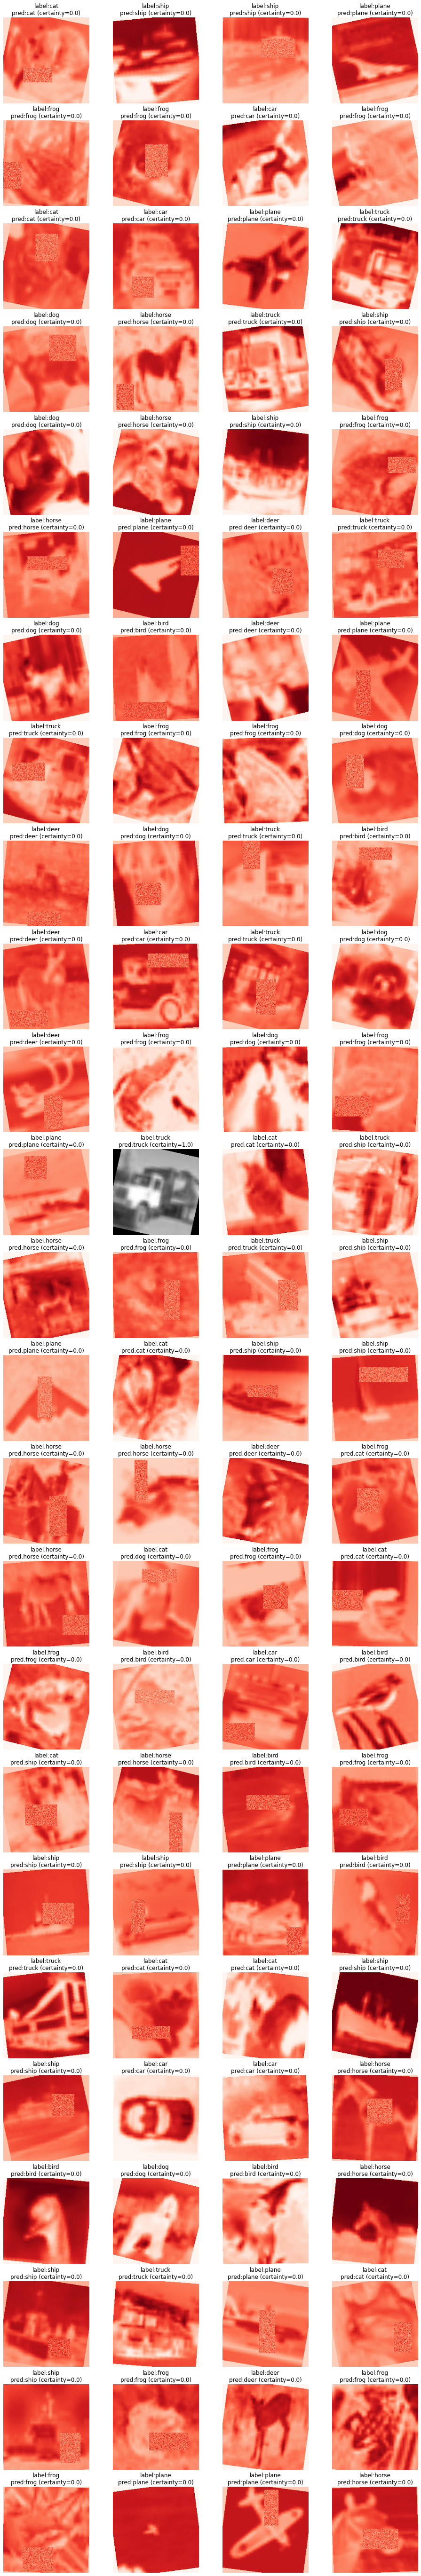

In [47]:
nc = 4
nr = labels_test.shape[0] // nc + 1

im_size = 4

plt.figure(figsize=(nc*im_size,nr*im_size))
for i in range(labels_test.shape[0]):
    pred_test = accuracy_attr_test['pred'].to('cpu')
    cmap_test = 'gray'
    
    certain_pred_test = accuracy_attr_test['certain_pred'].to('cpu')
  
    if certain_pred_test[i].item() == 0:
            cmap_test = 'Reds'
            
    plt.subplot(nr,nc,i+1)
    plt.imshow(inputs_test[i][0].to('cpu'), cmap = cmap_test)
    plt.axis('off')
    plt.title(f'label:{class_names[labels_test[i]]}' + 
              "\n" + f'pred:{class_names[pred_test[i].item()]}' + 
              f' (certainty={certain_pred_test[i].item()})'
             )
accuracy_attr_test

In [48]:
# for i, ps in enumerate(pred_test):
#     pred = class_names[pred_test[i].item()]
#     gt = class_names[classes_test[i]]
#     description = "\n".join(
#         ["class {}: {}%".format(classes_test[i], pred_test[i])])

## Log series of images and predictions 

In [49]:
# run["images/predictions"].log(
#     File.as_image(inputs_test[i].squeeze().permute(2, 1, 0).clip(0, 1)),
#     name=f"{i}_{pred}_{gt}",
#     description=description,
#     )

for param in model.parameters():
    print(param)

## Log the code

In [50]:
#run = neptune.init_run(source_files=["In-vivo_blood_count/2_Play_with_Uncertainty/EffNet_with_2_heads.ipynb"])

## Stop logging

In [51]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/avkornaev/Play-with-uncertainty/e/PLAY-253/metadata


In [52]:
model.parameters()

<generator object Module.parameters at 0x7f9cdd6efcf0>